In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
VERSION = "nightly"  #@param ["1.5" , "20200516", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4139  100  4139    0     0  26876      0 --:--:-- --:--:-- --:--:-- 27052
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
     |████████████████████████████████| 61kB 2.9MB/s 
Uninstalling torch-1.5.1+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly-cp36-cp36m-linux_x86_64.whl...
- [1 files][107.5 MiB/107.5 MiB]                                                
Operation completed over 1 objects/107.5 MiB.                                    
Copy

In [ ]:
# !pip install pretrainedmodels timm -q

     |████████████████████████████████| 61kB 2.1MB/s 


In [13]:
import os
from pathlib import Path
from google.colab import drive
import shutil

def create_path(path):
    if not os.path.isdir(path):
        path.mkdir(parents=True, exist_ok=True)
    return path

colab_path = Path(Path(os.path.abspath(os.curdir)))

In [ ]:
create_path(colab_path/'dataset');
create_path(colab_path/'models');

!git clone --quiet 'https://github.com/tezike/download_google_drive.git'
os.chdir('download_google_drive')
!python download_gdrive.py '10rH0nAxa7mWS289xIyRP-mOOowqiIolL' '../dataset/temp.tgz'
shutil.rmtree('../download_google_drive')
os.chdir('..')

## Colab_setup

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# root_dir = Path('/content/drive/My Drive')

root_dir = os.path.abspath(os.curdir)
base_path = create_path(root_dir/'Rakuten')
base_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PosixPath('/content/drive/My Drive/Rakuten')

In [ ]:
!pip install catalyst -q

In [ ]:
import os
import PIL
from tqdm.notebook import tqdm

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from timm import create_model
import albumentations as A
# from efficientnet_pytorch import EfficientNet
import pretrainedmodels
import pandas as pd
import numpy as np
from pathlib import Path
import gc; gc.collect()
from collections import Counter

from catalyst.data.sampler import DistributedSamplerWrapper

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Set up XLA

In [ ]:
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

## Config

In [ ]:
class Config():
    def __init__(self):
        self.COLAB_PATH = Path(os.path.abspath(os.curdir))
        self.BASE_PATH = base_path
        self.DATA_PATH = create_path(base_path/'dataset')
        self.MODEL_PATH = create_path(base_path/'models')
        self.IMAGE_TRAIN_PATH = self.COLAB_PATH/'SIGIR-2020-EComDC-release/image/image_training'
        self.IMAGE_TEST_PATH = self.COLAB_PATH/'SIGIR-2020-EComDC-release/image/image_test'
        self.TEST_FILE = self.COLAB_PATH/'SIGIR-2020-EComDC-release/data/x_test_task1_phase1.tsv'
        self.CLEAN_DF = self.DATA_PATH/'clean_folds_df.csv'
        self.TRAIN_BS = 16
        self.VALID_BS = 16
        self.NUM_EPOCHS = 12
        self.sz = 400
        self.MEAN = (0.485, 0.456, 0.406)
        self.STD = (0.229, 0.224, 0.225)
        self.lr = 7e-05

config = Config()

## Model

In [ ]:
# class Model(nn.Module):
#     def __init__(self, pretrained='imagenet'):
#         super(Model, self).__init__()
        
#         self.base_model = pretrainedmodels.__dict__[
#             "se_resnext50_32x4d"
#         ](pretrained=pretrained)

#         self.l0 = nn.Linear(2048, 1)
    
#     def forward(self, image):
#         batch_size, _, _, _ = image.shape
        
#         x = self.base_model.features(image)
#         x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        
#         out = self.l0(x)
#         return out

In [ ]:
class Model(nn.Module):
    def __init__(self, pretrained=False):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet50(pretrained=pretrained)
        self.model.fc = nn.Linear(in_features=2048, out_features=27)

    def forward(self, x):
        out = self.model(x)
        return out

## Dataset

In [ ]:
def onehot(size, target):
    vec = np.zeros(size, dtype=np.float32)
    vec[target] = 1.
    return vec

class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, lbls, augs=True, resize=False, is_train=True):

        self.img_paths = img_paths
        self.lbls = lbls
        self.augs = augs
        self.is_train = is_train
        self.resize = resize

    def __getitem__(self, i):
        img_path = self.img_paths[i]
        lbl = self.lbls[i]

        img = PIL.Image.open(img_path)

        if self.resize:
            img = img.resize((config.sz, config.sz), resample=PIL.Image.LANCZOS)
           
        img = np.asarray(img).astype(np.uint8)

        
        if self.augs:
            if self.is_train:
                data = {'image' : img}            
                data = self.get_train_transforms()(**data)
                img = data['image']
            elif not self.is_train:
                data = {'image':img}            
                data = self.get_valid_transforms()(**data)
                img = data['image']

        # img = np.array(img)/255.

        lbl = onehot(27, lbl)

        return {
            'image' : torch.tensor(img, dtype=torch.float).permute(2, 0, 1),
            'target' : torch.tensor(lbl, dtype=torch.float)
            }

        
    def __len__(self):
        return len(self.lbls)

    def get_train_transforms(self):
        return A.Compose([
                A.Normalize(config.MEAN, config.STD, max_pixel_value=255.0, always_apply=True),
                # A.RandomSizedCrop(min_max_height=(180, 180), height=224, width=224, p=0.5),
                # A.CenterCrop(config.sz, config.sz, always_apply=True),
                # A.CenterCrop(224, 224, always_apply=True),
                A.RandomRotate90(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                # A.ShiftScaleRotate(p=0.9),
                # A.RandomBrightnessContrast(),
                # A.Resize(height=512, width=512, p=1),
                # A.CoarseDropout(max_holes=8, max_height=32, max_width=32, min_holes=3, min_height=8, min_width=8, fill_value=0),                  
            ], p=1.0)

    def get_valid_transforms(self):
        return A.Compose([
                A.Normalize(config.MEAN, config.STD, max_pixel_value=255.0, always_apply=True),
                # A.CenterCrop(config.sz, config.sz, always_apply=True),
                # A.Resize(height=400, width=400, p=1.0),
            ], p=1.0)
    
    def get_labels(self):
        return list(self.lbls)

## Prep Data

In [ ]:
!tar -xzf 'dataset/temp.tgz'

In [ ]:
##NOTE: Put the df all file I sent to you inside the folder root/Rakuten/Dataset/df_all.csv

In [ ]:
df_all = pd.read_csv(config.DATA_PATH/'df_all.csv'); df_all.sample(1)

,Title,Description,Image_id,Product_id,Prdtypecode,Prdlbl,image_path
61569,Les Contes Populaires Du Languedoc,Le conte populaire est un conte oral tradition...,1270098765,298031778,2705,2705,/content/SIGIR-2020-EComDC-release/image/image...


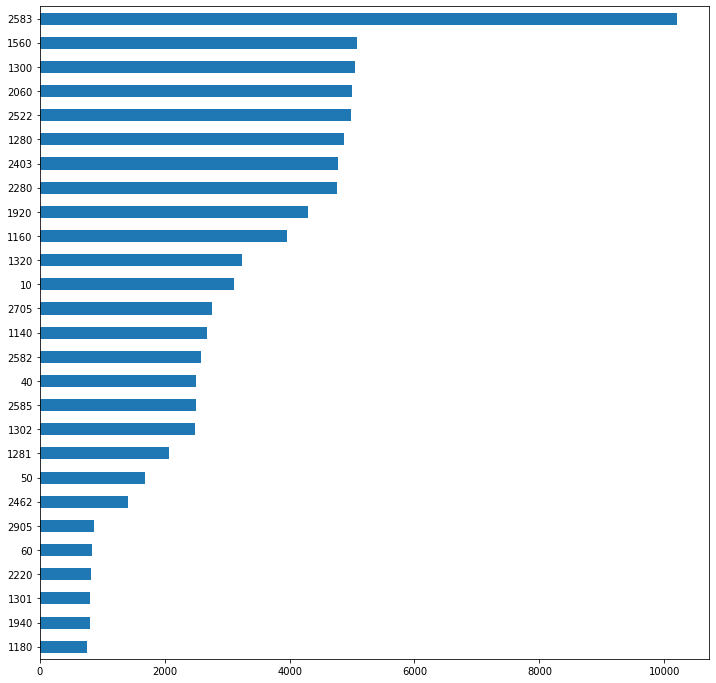

In [ ]:
df_all.Prdlbl.value_counts(ascending=True).plot.barh(figsize=(12,12))

NB: The Dataset is highly imbalanced so we will need a form of weighting or smapling

In [ ]:
le = LabelEncoder()

In [ ]:
le.fit(df_all.Prdlbl)
le.classes_

array([  10,   40,   50,   60, 1140, 1160, 1180, 1280, 1281, 1300, 1301,
       1302, 1320, 1560, 1920, 1940, 2060, 2220, 2280, 2403, 2462, 2522,
       2582, 2583, 2585, 2705, 2905])

In [ ]:
df_all.Prdlbl = le.transform(df_all.Prdlbl)

In [ ]:
df_all.shape

(84916, 7)

## Utils

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        if self.training:
            x = x.float()
            target = target.float()
            logprobs = torch.nn.functional.log_softmax(x, dim = -1)

            nll_loss = -logprobs * target
            nll_loss = nll_loss.sum(-1)
    
            smooth_loss = -logprobs.mean(dim=-1)

            loss = self.confidence * nll_loss + self.smoothing * smooth_loss

            return loss.mean()
        else:
            return torch.nn.functional.cross_entropy(x, target)

In [ ]:
def calc_metric(y_pred, y_true):
    return f1_score(y_true, y_pred, average='macro'), accuracy_score(y_true, y_pred)

def cross_entropy_loss(y_pred, y_true):
    return nn.CrossEntropyLoss()(y_pred, y_true.argmax(1).to(y_pred.device).long())

def focal_loss(y_pred, y_true):
    return FocalLoss(logits=True)(y_pred, y_true.to(y_pred.device))

def label_smoothing_loss(y_pred, y_true):
    return LabelSmoothing()(y_pred, y_true.to(y_pred.device))

def to_device(tensor_, device):
    return tensor_.to(device)

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Trainer(TPU)

In [ ]:
WRAPPED_MODEL = xmp.MpModelWrapper(Model(pretrained=True))

def _run():
    xm.master_print(f'Setting up...')
    
    device = xm.xla_device()
    
    global WRAPPED_MODEL
    model = WRAPPED_MODEL.to(device)
    
    model_path = config.MODEL_PATH/'model_resnet50.bin'

    # do the split just once and it'l be saved
    train_df, valid_df = train_test_split(df_all, test_size=0.2, stratify=df_all.Prdlbl, shuffle=True)

    # save the split ids so we can reuse the same split
    np.save(str(config.DATA_PATH/'train_index.npy'), train_df.index.values)
    np.save(str(config.DATA_PATH/'valid_index.npy'), valid_df.index.values)
    
    train_df_idx = np.load(str(config.DATA_PATH/'train_index.npy'), allow_pickle=True)
    valid_df_idx = np.load(str(config.DATA_PATH/'valid_index.npy'), allow_pickle=True)
    train_df = df_all.iloc[train_df_idx].reset_index(drop=True)
    valid_df = df_all.iloc[valid_df_idx].reset_index(drop=True)

    train_df, valid_df = train_df.reset_index(drop=True), valid_df.reset_index(drop=True)
    
    train_ds = Dataset(train_df.image_path, train_df.Prdlbl, resize=True)
    valid_ds = Dataset(valid_df.image_path, valid_df.Prdlbl, resize=True, is_train=False)
    
    weights = 1./ np.array(list(map(lambda x: x[1], sorted(Counter(train_df.Prdlbl.values).items(), key=lambda x: x[0]))))
    each_weight = np.array([weights[i] for i in train_df.Prdlbl.values])
    each_weight = torch.from_numpy(each_weight)

    train_sampler = DistributedSamplerWrapper(sampler=torch.utils.data.WeightedRandomSampler(each_weight.double(), len(each_weight)), 
                                                        num_replicas=xm.xrt_world_size(),
                                                        rank=xm.get_ordinal(),
                                                        shuffle=True)

    
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=config.TRAIN_BS, drop_last=True, 
                                           num_workers=0, sampler=train_sampler)
    
    valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_ds, 
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle=False)

    valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_ds, 
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle=False)

    
    valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=config.VALID_BS, drop_last=False, 
                                           num_workers=0, sampler=valid_sampler)
    
    def train(dl, model, opt, device, sched=None):
        xm.master_print('TRAINING...')
        model.train()
        loss_meter = AverageMeter()
        all_losses = []

        p_bar = tqdm(dl, total = len(dl), disable=not xm.is_master_ordinal())

        for i, batch in enumerate(dl):
            images = batch['image']
            targets = batch['target']

            images = to_device(images, device)
            targets = to_device(targets, device)

            opt.zero_grad()

            out = model(images)
            # loss = cross_entropy_loss(out, targets)
            loss = label_smoothing_loss(out, targets)

            loss_meter.update(loss.item(), images.shape[0])
            
            if i % 4000 == 0:
                xm.master_print(f'Batch: {i}, Training loss: {loss_meter.avg}')

            all_losses.append(loss.item())    

            loss.backward()
            xm.optimizer_step(opt)

            p_bar.set_postfix(loss=loss_meter.avg)
            # break

        return all_losses


    def evaluate(dl, model, device, metrics=False):
        model.eval()
        xm.master_print('EVALUATING...')
        loss_meter = AverageMeter()

        all_outs = []
        all_targets = []

        p_bar = tqdm(dl, total = len(dl), disable=not xm.is_master_ordinal())

        with torch.no_grad():

            for i, batch in enumerate(dl):
                images = batch['image']
                targets = batch['target']

                images = to_device(images, device)
                targets = to_device(targets, device)
                
                out = model(images)
                
                # loss = cross_entropy_loss(out, targets)
                loss = label_smoothing_loss(out, targets)

                loss_meter.update(loss.item(), images.shape[0])
                
                if i % 4000 == 0:
                    xm.master_print(f'Batch: {i}, Evaluation loss: {loss_meter.avg}')

                out = F.softmax(out, dim=1).argmax(1)

                all_outs.extend(out.cpu().detach().tolist())
                all_targets.extend(targets.argmax(1).cpu().detach().tolist())
                # break

                p_bar.set_postfix(loss=loss_meter.avg)


        xm.master_print(f'VALID LOSS = {loss_meter.avg}')

        return loss_meter.avg, all_outs, all_targets
    
    
    lr = config.lr * xm.xrt_world_size()
    
    opt = torch.optim.AdamW(model.parameters(), lr = lr)
    # opt = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=0.1, nesterov=True)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, mode='min')
    # sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, total_steps=10000, epochs=3, steps_per_epoch=len(train_ds))
    
    
    best_metric = 0

    for epoch in range(config.NUM_EPOCHS):
        epoch_start = time.time()
        xm.master_print('-'*50)
        xm.master_print(f'Running Epoch #{epoch} {"🔥"*epoch}')
        xm.master_print(f'{"-"*50} \n')

        train_para_loader = pl.ParallelLoader(train_dl, [device])
        valid_para_loader = pl.ParallelLoader(valid_dl, [device])
        
        start = time.time()
        all_train_losses = train(train_para_loader.per_device_loader(device), model, opt, device, sched)
        end = time.time()
        xm.master_print(f'Training time: {round(end-start, 2)} secs')
        
        start = time.time()
        loss, all_outs, all_targets = evaluate(valid_para_loader.per_device_loader(device), model, device)
        end = time.time()
        xm.master_print(f'Evaluation time: {round(end-start, 2)} secs \n')
        
        f1_score_, accuracy = calc_metric(all_outs, all_targets)


        xm.master_print(f'VALID F1-SCORE: {f1_score_}')
        xm.master_print(f'ACCURACY SCORE: {accuracy}')


        if f1_score_ > best_metric:
            torch.save(model.state_dict(), model_path)
            xm.master_print('Validation score improved ({} --> {}). Saving model!'.format(best_metric, f1_score_))
            best_metric = f1_score_

        epoch_end = time.time()
        
        xm.master_print('-'*50)
        xm.master_print(f'TOTAL EPOCH TIME: {round(epoch_end-epoch_start, 2)} secs \n')
        
        # if sched is not None:
        sched.step(loss)
        # break

In [ ]:
gc.collect()

41

In [ ]:
# fold = 0
FLAGS = {}
def mp_wrapper(rank, flags):
    torch.set_default_tensor_type('torch.FloatTensor')
    _run()
    
xmp.spawn(mp_wrapper, args=(FLAGS, ), nprocs=8, start_method='fork')

Setting up...
--------------------------------------------------
Running Epoch #0 
-------------------------------------------------- 

TRAINING...


Batch: 0, Training loss: 3.3881049156188965
Training time: 1471.9 secs
EVALUATING...
Batch: 0, Evaluation loss: 1.9932258129119873
VALID LOSS = 2.4450175608321847
Evaluation time: 295.29 secs 

VALID F1-SCORE: 0.35526982270841956
ACCURACY SCORE: 0.39849269901083373
Validation score improved (0 --> 0.35526982270841956). Saving model!
--------------------------------------------------
TOTAL EPOCH TIME: 1784.58 secs 

--------------------------------------------------
Running Epoch #1 🔥
-------------------------------------------------- 

TRAINING...


Batch: 0, Training loss: 2.2590765953063965
Training time: 1507.63 secs
EVALUATING...
Batch: 0, Evaluation loss: 2.3472695350646973
VALID LOSS = 2.1592694711303353
Evaluation time: 278.78 secs 

VALID F1-SCORE: 0.45534947711182705
ACCURACY SCORE: 0.4936410739519548
Validation score improved (0.35526982270841956 --> 0.45534947711182705). Saving model!
--------------------------------------------------
TOTAL EPOCH TIME: 1803.6 secs 

--------------------------------------------------
Running Epoch #2 🔥🔥
-------------------------------------------------- 

TRAINING...


Batch: 0, Training loss: 1.7821650505065918
Training time: 1406.41 secs
EVALUATING...
Batch: 0, Evaluation loss: 2.0636157989501953
VALID LOSS = 2.010485548710295
Evaluation time: 265.68 secs 

VALID F1-SCORE: 0.5150043709217603
ACCURACY SCORE: 0.5369759773904852
Validation score improved (0.45534947711182705 --> 0.5150043709217603). Saving model!
--------------------------------------------------
TOTAL EPOCH TIME: 1688.04 secs 

--------------------------------------------------
Running Epoch #3 🔥🔥🔥
-------------------------------------------------- 

TRAINING...


Batch: 0, Training loss: 1.5487674474716187
